In [3]:
from AC import preproc
from AC import get_news
import inspect
import nltk
nltk.download("stopwords")

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
economia = get_news("./articoli_economia/")
cultura = get_news("./articoli_cultura/")
tech = get_news("./articoli_tech/")
politica = get_news("./articoli_politica/")
sport = get_news("./articoli_sport/")
cronaca = get_news("./articoli_cronaca/")

for articolo in economia:
    articolo['categoria'] = "Economia"
for articolo in cultura:
    articolo['categoria'] = "Cultura"
for articolo in tech:
    articolo['categoria'] = "Tech"
for articolo in politica:
    articolo['categoria'] = "Politica"
for articolo in sport:
    articolo['categoria'] = "Sport"
for articolo in cronaca:
    articolo['categoria'] = "Cronaca"
dati_preprocessati =  preproc(tech + politica + cultura + economia + sport + cronaca)

100%|██████████| 2400/2400 [00:16<00:00, 148.94it/s]


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import linear_model,metrics

In [14]:
seed = 0
train_documents,test_documents = train_test_split(dati_preprocessati,random_state=seed, train_size=0.75)
test_documents, val_documents = train_test_split(test_documents,random_state=seed,train_size=0.5)

C:\Users\Cristy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
docs_texts = [' '.join([word for word in x['testo']] + x['tags'] + x['sottotitolo'] + x['titolo_articolo']) for x in dati_preprocessati]
train_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in train_documents]
test_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in test_documents]
val_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in val_documents]

docs_cats = [x["categoria"] for x in dati_preprocessati]
train_cats = [x["categoria"] for x in train_documents]
test_cats = [x["categoria"] for x in test_documents]
val_cats = [x["categoria"] for x in val_documents]

# Tabelle finali

In [13]:
#tabella con accuratezza (fissato il trainig set, dire perche' fissata questa dimensione(50% o 75%)) di dummy, di LDA(forse 2 numero di componenti), senza LDA
#tabella con altre misure di valutazione del modello con il modello migliore(LDA)
#previsione con nuovi articoli

In [14]:
dc = DummyClassifier("most_frequent")

dc.fit(train_texts, train_cats)

y_pred = dc.predict(test_texts)
dc_acc = accuracy_score(test_cats, y_pred)

print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))

Accuratezza DummyClassifier("most_frequent"): 15.0%


In [16]:
ldac = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("lda", LatentDirichletAllocation(max_iter=50, learning_method='online',random_state=0)),
    ("classifier",DecisionTreeClassifier(random_state=0))
])
params = {
    'lda__n_components': 12,
    'lda__learning_decay': 0.7, 
    'count_mx__ngram_range': (1, 3), 
    'count_mx__min_df': 10, 
    'count_mx__max_df': 0.5, 
    'classifier__min_samples_leaf': 1, 
    'classifier__max_depth': 22
}
ldac.set_params(**params)

Pipeline(memory=None,
     steps=[('count_mx', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=1000000, min_df=10,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

In [134]:
tfc = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("classifier",DecisionTreeClassifier(random_state=0))
]) 
params = { 
    'count_mx__ngram_range': (1, 3), 
    'count_mx__min_df': 1, 
    'count_mx__max_df': 200, 
    'classifier__min_samples_leaf': 1, 
    'classifier__max_depth':  65
}
tfc.set_params(**params)

Pipeline(memory=None,
     steps=[('count_mx', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=200, max_features=1000000, min_df=10,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

In [17]:
ldac.fit(train_texts, train_cats)
pred_cats = ldac.predict(test_texts)
ldac_acc = accuracy_score(test_cats, pred_cats)

In [169]:
tfc.fit(train_texts, train_cats)
pred_cats = tfc.predict(test_texts)
tfc_acc = accuracy_score(test_cats, pred_cats)

In [170]:
#costruire tabella con dc_acc, ldac_acc, tfc_acc (eventualmente fare due con lda)

In [171]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
from itertools import product

0.99


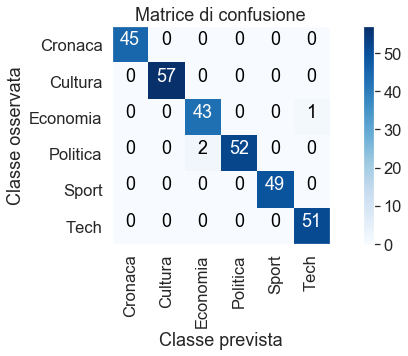

In [172]:
classi = unique_labels(test_cats, pred_cats)
plt.title("Matrice di confusione")
cm = confusion_matrix(test_cats, pred_cats)
    
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(fraction=0.04, pad=0.1)#spazi occupati dalla barra a destra

#labels 
tick_marks = range(len(classi))
plt.xticks(tick_marks, classi, rotation=90)
plt.yticks(tick_marks, classi)
    
plt.grid(None)
  
thresh = cm.max() / 2
#colore dei numeri dentro i quadrati
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
plt.ylabel("Classe osservata")
plt.xlabel("Classe prevista")
print(metrics.accuracy_score(pred_cats, test_cats)) 


In [173]:
print(classification_report(test_cats, pred_cats, target_names=unique_labels(test_cats, pred_cats)))

              precision    recall  f1-score   support

     Cronaca       1.00      1.00      1.00        45
     Cultura       1.00      1.00      1.00        57
    Economia       0.96      0.98      0.97        44
    Politica       1.00      0.96      0.98        54
       Sport       1.00      1.00      1.00        49
        Tech       0.98      1.00      0.99        51

   micro avg       0.99      0.99      0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



# Previsione di nuovi articoli

In [22]:
from estrattore_dati.estrattore_articoli_ansa import estrai
#p = estrai("http://www.ansa.it/sito/notizie/tecnologia/hitech/2019/06/03/amazon-apre-negozio-a-manchester_24353478-6d22-43b4-89d6-32725e95bf09.html")
#p = {"titolo_articolo":"Conte verso l'ultimatum a e M5s e chiede chiarimenti sullo sblocca-cantieri","testo":"Il discorso di Conte Negli ultimi giorni, a chi gli faceva domande sul destino del governo, Giuseppe Conte ha risposto rinviando all'incontro con i giornalisti di \"luned\u00EC\". Oggi dunque - a borse chiuse - pronuncer\u00E0 un discorso molto atteso in cui, presumibilmente, lancer\u00E0 un aut aut: evocando in qualche modo la possibilit\u00E0 di dimissioni. Questo nel caso in cui non ci sia un'inversione di tendenza nella rissa continua tra Lega e 5Stelle. E se continuer\u00E0 la linea di rottura con Bruxelles.repApprofondimentoOggi l'ultimatum di Conte: \u201CTrattativa con la Ue o lascio\u201Ddi TOMMASO CIRIACONel mirino di Conte c'\u00E8 soprattutto Salvini che - dopo il ribaltamento dei rapporti di forza coni 5Stelle - si muove a tutto campo come fosse il presidente del Consiglio. Il malumore di Conte \u00E8 stato visibile gi\u00E0 nei giorni scorsi quando ha chiarito: \"Gli emendamenti governativi vanno discussi nella sede del governo che \u00E8 Palazzo Chigi\", un riferimento alle modifiche presentate dalla Lega allo Sblocca-cantieri. O quando ha frenato la corsa leghista verso la flat tax.Centinaio: il premier faccia un miracoloIl primo a sperare che il discorso del premier faccia miracoli \u00E8 il ministro dell'Agricoltura Gian Marco Centinaio, ospite di Circo Massimo su Radio Capital: \"Auspico che il presidente Conte faccia un miracolo. Continuo a essere dell'idea che la campagna elettorale \u00E8 finita e i toni si devono abbassare. Il premier deve ricominciare a far parlare la politica, e soprattutto i due contraenti del contratto, di cose concrete\". Ma poi aggiunge che da parte della Lega \"c'\u00E8 la buona volont\u00E0, ma se non ci dovessero essere le condizioni, se non si riesce a mettersi d'accordo, non vedo alternativa a elezioni\".Governo, il ministro Centinaio: \"Abbassiamo i toni, Conte faccia il miracolo: l'alternativa \u00E8 il voto\"CondividiSblocca-cantieri e decreto crescitaCi sono due importanti decreti - vicini alla scadenza - ad agitare i rapporti tra i gialloverdi: uno \u00E8 lo sblocca-cantieri, previsto in aula per domani, su cui si combatte la sfida del Codice degli appalti. La Lega ha presentato un emendamento che intende bloccare il Codice per due anni. Salvini ha detto che frena il Paese, i 5Stelle non sono d'accordo. Il presidente della Commissione parlamentare antimafia - il grillino Nicola Morra - ha detto che il subappalto libero \u00E8 un \"grimaldello\" per la criminalit\u00E0 organizzata.In merito Salvini questa mattina, nell'inaugurare vicino a Vicenza il primo tratto della Pedemontana veneta con il governatore Zaia, ha commentato con una battuta la convocazione ricevuta da Conte per le 17.30 di oggi a Palazzo Chigi: \"Oggi ho ricevuto una lettera del presidente del Consiglio che convoca una riunione sullo Sblocca cantieri. Beh, io sono stamattina qui, il cantiere \u00E8 sbloccato\". E sul tema delle infrastrutture, invita il governo a rompere gli indugi sulle grandi opere: \"Se uno ha paura cambi mestiere, perch\u00E8 \u00E8 il momento del coraggio\".E poi c'\u00E8 il decreto crescita che \u00E8 oggi in commissione Finanze e domani dovrebbe approdare in aula. Manca l'accordo sul cosiddetto \"Salva-Roma\" sui debiti della capitale, ma - vista la freddezza tra la sindaca Raggi e Luigi Di Maio - il provvedimento non \u00E8 pi\u00F9 considerato una priorit\u00E0 dai vertici M5S.La risposta Ue alla lettera di TriaArriver\u00E0 dopodomani la risposta di Bruxelles alla lettera del governo sui conti. Lo ha confermato sabato un portavoce della Commissione. L'avvio di una procedura d'infrazione per il debito \u00E8 sempre pi\u00F9 probabile. Con ripercussioni temibili sui mercati. Ma sul governo pesa anche la denuncia di Tria contro la \"manina\" che ha diffuso la prima versione della lettera (nel mirino i 5Stelle).Resta da capire come si muoveranno le due forze politiche nel rapporto conl'Ue. Luigi Di Maio ha perso, negli ultimi giorni, l'afflato europeista manifestato durante la campagna elettorale. Ma \u00E8 certo che a fare la voce grossa con Bruxelles, nelle ultime ore, \u00E8 stato soprattutto Matteo Salvini dicendo: \"Vedremo chi ha la testa pi\u00F9 dura\". Ci saranno spaccature su questo tra gli alleati? Di sicuro Conte non sembra intenzionato ad avallare una procedura d'infrazione.La flat taxPer Salvini la flat tax resta una priorit\u00E0. \"Il governo va avanti se mantiene l'impegno di tagliare le tasse, presto e bene\", ha ripetuto anche ieri. Lasciando intendere che su questo \u00E8 pronto a tornare al voto. Ma - se i 5Stelle sul tema hanno aperto - il presidente del Consiglio non sembra disposto a tollerare un flat tax finanziata in deficit. Perch\u00E9 significherebbe la sfida finale all'Ue.repApprofondimentoFico-Salvini, lite sui rom per accelerare la crisidi CARMELO LOPAPAIl consiglio dei ministriIl premier Conte sar\u00E0 - mercoled\u00EC e gioved\u00EC - in visita in Vietnan. Salvini ha lasciato intendere che vorrebbe un Consiglio dei ministri venerd\u00EC: \"Finalmente sar\u00E0 approvato il decreto sicurezza bis contro scafisti, camorristi, spacciatori, teppisti da stadio\", ha detto. Ma, al di l\u00E0 del decreto sicurezza bis - di cui tanto si \u00E8 discusso nelle ultime settimane - la riunione potrebbe essere il momento della resa dei conti su tutti i nodi in sospeso. Tutti intorno a un tavolo, Conte e i due vicepremier. E tra i tanti temi di divisione c'\u00E8 - e non \u00E8 secondario - quello delle autonomie.", "sottotitolo":"Il ministro Centinaio a Circo Massimo: \"Faccia un miracolo o si va al voto\". Prevista anche una riunione sullo sblocca-cantieri a Palazzo Chigi. Nei prossimi giorni una serie di appuntamenti potrebbero essere l'occasione per uno scontro finale tra Lega e 5Stelle", "tags":["","governo conte","lettera Ue","Commissione Ue","lega","Circo Massimo","Giuseppe Conte","Luigi Di Maio","Matteo Salvini","Gian Marco Centinaio"]}
#p = {"titolo_articolo":"La bella storia di Vittorio Zucconi", "sottotitolo":"I ricordi di una vita, i personaggi incrociati: in edicola con \"Repubblica\" il libro del grande giornalista scomparso: \"Il lato fresco del cuscino\"","tags":["Libri","Vittorio Zucconi"],"testo":"Tra gli umani sentimenti ingiustamente additati c'è con ogni evidenza l'invidia. Più che un peccato, rappresenta un bivio. Successivo a una consapevolezza, e cioè che l'altro sia più bravo di te. Puoi dolertene, puoi accettarlo. E vivere abbastanza sereno ugualmente. Con uno sprone in più.Io ero e sono invidioso di Vittorio Zucconi. Della sua qualità di scrittura, della sua leggerezza corposa, del suo approccio laterale al mondo. Uno che stava da Papa a Mosca come a Washington, passando per Milano Marittima, con l'attitudine, col tempo anche fisica, di un Hemingway della tigella al pesto.In questi giorni maldestri, in cui microbi della Storia come il senatore Pillon hanno inteso riversare la propria miseria su chi ne aveva disvelato, via radio, la rotonda inutilità, molti hanno ricordato l'attitudine a romanzare di Vittorio. Qualcuno, specie i senza talento, con una punta di derisione.Ma era gente che al bivio di cui sopra aveva preso la strada che porta alla frustrazione. Quelli che, quando muore uno figo, vorrebbero che quei commenti fossero per loro. Né vale citare l'antico adagio giornalistico, inutilmente cinico, secondo cui una bella storia non dovrebbe mai essere rovinata con la verità.Quella di Zucconi è la verità. La sua. Viva, umanissima. Brillante. Innervata da quella deriva amorosa con la reazione all'imprevisto, lo scatto di reni sul girar di rotative, la notizia da riconoscere al balzo, che solo i giornalisti migliori, cioè gli interpreti più nobili di un mestiere che, nonostante tutto rimane nobile a sua volta, sanno pescare in loro stessi.Un bel libro parte spesso da un bel titolo. Nella parte fresca del cuscino c'è l'immagine di una requie che ognuno di noi ha cercato almeno una volta nella vita. Leggi quella frase e senti la guancia sulla federa. Così come, nell'incedere delle pagine, immagini la grisaglia di Mike Bongiorno nel casermone in cui abitava il papà di Vittorio, Guglielmo. Vedi il flan di piselli che assaggiava. Immagini la Bianchina su cui il giovane Zucconi si ribalta senza conseguenze, come una Comaneci dell'autoscontro. Vedi, fisicamente, l'aeroplanino di latta fatto coi resti delle bibite lasciate dagli americani in Vietnam, o la vecchietta che spaccia orologi sovietici destinati a fermarsi in un lampo di Perestrojika.Sei con lui, sei lui. C'è una finitezza ostentata, quasi autoavverante, lungo i capitoli di quello che non è un libro triste. Ma ha il tono malinconico e allegro del bilancio.C'è una fila di chiuse, come diciamo noi tossici del piombo (da stampa) che valgono il singolo capitolo. Compongono, tutte insieme, quasi una frase di senso compiuto: \"Nessuno dovrà mai deporre un santino per un robot\". \"Se avessi avuto ancora con me il mio vecchio computer, sono sicuro che finalmente avrebbe saputo scrivere un bel racconto\". \"La rivoluzione non finirà con un'esplosione, ma con un giocattolo\". \"Era finita la mia giovinezza\".Nell'esegesi postuma da cui le persone realmente ironiche andrebbero esentate per decreto, qualcuno ha inteso divaricare lo Zucconi social, quello radiofonico, il cronista, lo scrittore, come se i primi due rivestissero minor dignità. Le crociate contro l'analfabetismo grillino, i duetti di giornalismo carpiato con Edoardo Buffoni, le sue corrispondenze, questo libro, sono invece tutti figli degli stessi lombi. Quelli di un fuoriclasse.Narciso, generoso, coraggioso, creativo, entusiasta. Scegliete l'aggettivo che preferite e applicatelo: avrete il \"vostro\" Vittorio Zucconi. Come lui aveva sempre la sua storia da raccontare.Qui, ora.Ancora.Il libro di Vittorio Zucconi, \"Il lato fresco del cuscino\", sarà in vendita da domani con Repubblica al prezzo di 9,90 euro più il costo del giornale "}

x_1 = preproc([p])

ldac.predict([' '.join(x_1[0]['testo'] +x_1[0]['titolo_articolo']+x_1[0]['sottotitolo'] + x_1[0]['tags'])])

100%|██████████| 1/1 [00:00<00:00, 124.81it/s]


array(['Sport'], dtype='<U8')